**Import Libraries**

In [121]:
from unidecode import unidecode
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor 
from sklearn.metrics import mean_absolute_error, r2_score 
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score
import time
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier

/opt/anaconda3/lib/python3.8/site-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


**Trankfrmrkt Data**

In [49]:
players_df = pd.read_csv('players.txt', delimiter=',')
player_valuations_df = pd.read_csv('player_valuations.txt', delimiter=',')

In [50]:
#keep relevant columns
players_df = players_df[['player_id', 'name']]

#change type of 'dateweek' (week trasnfrmrkt priced player)
player_valuations_df['dateweek'] = pd.to_datetime(player_valuations_df['dateweek'])

In [51]:
#keep prices given to player between june and december 2022. This is what we will train model on 

min_cutoff_date = pd.to_datetime("2022-06-01")
max_cutoff_date = pd.to_datetime("2023-01-01")

# Filter for rows in 2022 and after June 1, 2022
filtered_cutoff_df = player_valuations_df[(player_valuations_df['dateweek'] >= min_cutoff_date) & (player_valuations_df['dateweek'] < max_cutoff_date)]

# Group the filtered DataFrame and select the earliest 'dateweek' after June 1, 2022 for each player
earliest_after_june_df = filtered_cutoff_df.groupby('player_id', group_keys=False).apply(lambda x: x[x['dateweek'] == x['dateweek'].min()])

In [52]:
#Join player name to valuation through 'player_id'
result_df = pd.merge(earliest_after_june_df, players_df, on='player_id', how='inner')

In [53]:
#define function to remove special characters from player names. Will useful when joining players to their corresponding statistics. 
def strip_accents_and_punctuation(text):
    return unidecode(text)

In [54]:
#make new 'modified_name' column to be used later
result_df['modified_name'] = result_df['name'].apply(strip_accents_and_punctuation)

In [55]:
#there should not be any duplicates, but just in case:
result_df = result_df.drop_duplicates(subset='player_id', keep="last")

In [56]:
#ensure no duplicates by player_id
if len(result_df) != result_df.player_id.nunique():
    print("The players in the dataset are not unique; there are repeated players")
else:
    print("No duplicates by player_id")

No duplicates by player_id


In [57]:
#there are different players who have the same name -- will be dropping these for simplicity 
duplicate_names = result_df[result_df.duplicated(subset='modified_name', keep=False)]

# Filter out players with duplicate 'name'
result_df_no_dups = result_df[~result_df['modified_name'].isin(duplicate_names['modified_name'])]

if result_df_no_dups.modified_name.nunique() == len(result_df_no_dups):
    print("No players with same name in the dataset")
else:
    print("Multiple players with the same name")

No players with same name in the dataset


In [58]:
print(f"Total number of players with valuations (and unique names) following the 2021-2022 season: {len(result_df_no_dups)}")

Total number of players with valuations (and unique names) following the 2021-2022 season: 17167


**Player Statistics**

In [75]:
#Open csv file web-scraped by Tomi containing player statistics (and other metrics)
League_20_22_stats_df = pd.read_csv('full_top5_2020-2022.csv')
if 'Unnamed: 0' in League_20_22_stats_df.columns.to_list():
    League_20_22_stats_df = League_20_22_stats_df.drop(columns = ['Unnamed: 0'])

In [76]:
#All these players are unique, but will remove ones with duplicate names for simplicity 
duplicated_names = League_20_22_stats_df[League_20_22_stats_df.duplicated(subset='Player', keep=False)]
League_20_22_stats_df_no_dups = League_20_22_stats_df[~League_20_22_stats_df['Player'].isin(duplicated_names['Player'])]

In [77]:
if League_20_22_stats_df_no_dups.Player.nunique() == len(League_20_22_stats_df_no_dups):
    print("No players with same name in the dataset")
else:
    print("Multiple players with the same name")

No players with same name in the dataset


In [78]:
#Adding some modified fields based on Tomi's data

#changing player age to numerical format
League_20_22_stats_df_no_dups['Age'] = League_20_22_stats_df_no_dups['Age'].str.split('-')

#Convert the elements to integers
League_20_22_stats_df_no_dups['Age'] = League_20_22_stats_df_no_dups['Age'].apply(lambda x: (int(x[0]), int(x[1])))

# Calculate 'modified_age' as 'years + days/365'
League_20_22_stats_df_no_dups['modified_age'] = League_20_22_stats_df_no_dups['Age'].apply(lambda x: x[0] + x[1] / 365)

# Calculate the absolute difference between 26 years and 'modified_age'
League_20_22_stats_df_no_dups['distance_to_prime'] = abs(25 - League_20_22_stats_df_no_dups['modified_age'])

forward_substrings = ['FW', 'RW', 'LW', 'RM', 'CM', 'AM', 'MF']

# Update the 'Pos' values to 'Forward' if they contain the specified substrings
for substring in forward_substrings:
    League_20_22_stats_df_no_dups.loc[League_20_22_stats_df_no_dups['Pos'].str.contains(substring), 'modified_position'] = 'Attacker'

# Fill remaining positions as 'Defender' by default
League_20_22_stats_df_no_dups['modified_position'].fillna('Defender', inplace=True)

League_20_22_stats_df_no_dups['is_gk'] = League_20_22_stats_df_no_dups['Pos'].str.contains('GK').astype(int)

In [79]:
player_data_df = pd.merge(League_20_22_stats_df_no_dups, result_df_no_dups, 
                                  left_on='Player', right_on='modified_name', how='inner')

In [80]:
#Keeping relevant columns after join
player_data_df = player_data_df[['Player', 'Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY',
                                 'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA',
                                 'GCA', 'Cmp', 'PAtt', 'PrgP', 'Carries', 'PrgC', 'DAtt', 'Succ',
                                 'PCmp%', 'Nation', 'Pos', 'Age', 'Team', 'annual_wages',
                                 'total_transfers', 'market_value_in_eur', 'modified_age', 'distance_to_prime',
                                'modified_position', 'is_gk']]

**Ridge Regression** 

Preparation

In [81]:
#listing numerical features
numerical_features = ['Min', 'Gls', 'Ast', 'PK', 'PKatt', 'Sh', 'SoT', 'CrdY',
                      'CrdR', 'Touches', 'Tkl', 'Int', 'Blocks', 'xG', 'npxG', 'xAG', 'SCA',
                      'GCA', 'Cmp', 'PAtt', 'PrgP', 'Carries', 'PrgC', 'DAtt', 'Succ',
                      'PCmp%','annual_wages', 'total_transfers', 'modified_age']

In [82]:
#Will model for non-Goalkeeper players
player_data_df = player_data_df[player_data_df['is_gk'] == 0]

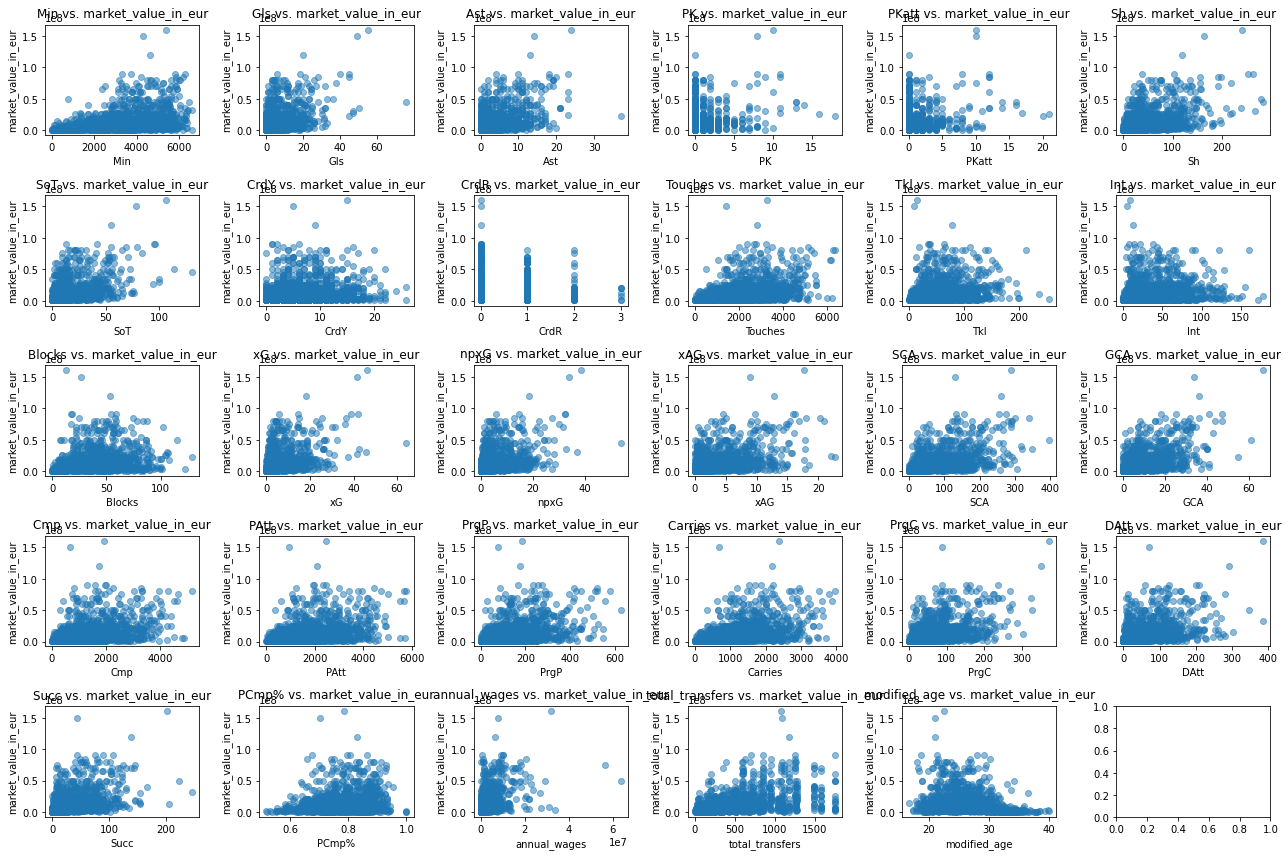

In [86]:
# Set target variable
target_variable = 'market_value_in_eur'

# Create subplots for each feature
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(18, 12))
fig.tight_layout(pad=3.0, h_pad=3.0)  # Adjust layout and padding

for i, feature in enumerate(numerical_features):
    row, col = i // 6, i % 6
    ax = axes[row, col]

    # Scatter plot
    ax.scatter(player_data_df[feature], player_data_df[target_variable], alpha=0.5)

    # Set title with improved position
    ax.set_title(f'{feature} vs. {target_variable}',  y=1.02)  # Adjust the 'y' parameter

    # Set labels
    ax.set_xlabel(feature)
    ax.set_ylabel(target_variable)

# Adjust the overall layout
plt.subplots_adjust(top=0.88)
plt.tight_layout()

# Display the plot
plt.show()


- Note that that it would not make sense to keep PK, PKatt in this context due to theri relationship with the target variable
- Same idea for CrdY and CrdR

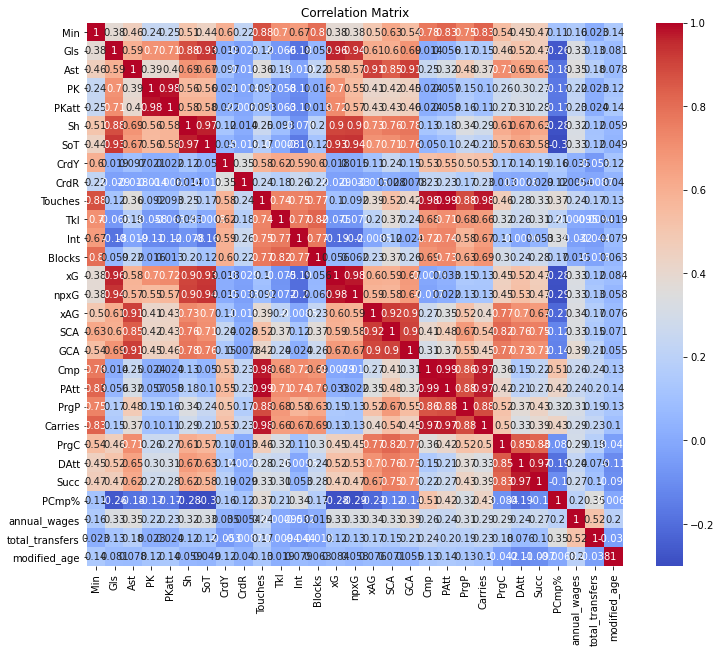

Pairs of features with correlation above 0.9:
Gls and SoT: 0.93
Gls and xG: 0.96
Gls and npxG: 0.94
Ast and xAG: 0.91
Ast and GCA: 0.91
PK and PKatt: 0.98
Sh and SoT: 0.97
Sh and xG: 0.90
Sh and npxG: 0.90
SoT and xG: 0.93
SoT and npxG: 0.94
npxG and xG: 0.98
SCA and xAG: 0.92
GCA and SCA: 0.90
Cmp and Touches: 0.98
Cmp and PAtt: 0.99
PAtt and Touches: 0.99
Carries and Touches: 0.98
Carries and Cmp: 0.97
Carries and PAtt: 0.97
DAtt and Succ: 0.97


In [87]:
#Calculate the correlation matrix
correlation_matrix = player_data_df[numerical_features].corr()

# Create a heatmap for the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

#Find pairs of features with correlation above 0.9
highly_correlated_pairs = [(feature1, feature2) for feature1 in numerical_features for feature2 in numerical_features if feature1 < feature2 and abs(correlation_matrix.loc[feature1, feature2]) > 0.9]

#Print the highly correlated pairs
if len(highly_correlated_pairs) > 0:
    print("Pairs of features with correlation above 0.9:")
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {correlation_matrix.loc[pair[0], pair[1]]:.2f}")
else:
    print("No pairs of features with correlation above 0.9.")

- The pairs above are highly correlated, we want to remove highly correlated features as this is one of the assumptions of linear regression 

In [88]:
correlated_things_to_remove = ['SoT', 'npxG', 'Sh', 'xAG', 'Cmp','PAtt', 'Carries', 'DAtt', 'CrdY', 'CrdR', 'PK', 'PKatt']
features_to_use = list(set(numerical_features) - set(correlated_things_to_remove))

In [90]:
player_data_x = player_data_df[features_to_use]
player_data_y = player_data_df['market_value_in_eur']

Modeling

In [91]:
#split into training, validation, and test
player_data_X_train, temp_data, player_data_y_train, player_data_y_temp = train_test_split(player_data_x, 
                                                                                           player_data_y, test_size=0.4, random_state= 42)

player_data_X_val, player_data_X_test, player_data_y_val, player_data_y_test = train_test_split(temp_data, player_data_y_temp, 
                                                                                                test_size=0.5, random_state= 42)

In [92]:
#Scale the data and add a bias term 
scaler = StandardScaler()
scaler.fit(player_data_X_train)

player_data_X_train= scaler.transform(player_data_X_train)
player_data_X_val = scaler.transform(player_data_X_val)
player_data_X_test = scaler.transform(player_data_X_test)

player_data_X_train = np.hstack([np.ones((player_data_X_train.shape[0], 1)), player_data_X_train])
player_data_X_val = np.hstack([np.ones((player_data_X_val.shape[0], 1)), player_data_X_val])
player_data_X_test = np.hstack([np.ones((player_data_X_test.shape[0], 1)), player_data_X_test])

Non - optimized model

In [93]:
#Train the Ridge regression model on the training data
ridge = Ridge(alpha=0.0)  # You can adjust alpha as needed
ridge.fit(player_data_X_train, player_data_y_train)

#Predict on the training set
y_train_pred = ridge.predict(player_data_X_train)

#Predict on the validation set
y_val_pred = ridge.predict(player_data_X_val)

#Predict on the test set
y_test_pred = ridge.predict(player_data_X_test)

#Calculate R^2 scores
r2_train = r2_score(player_data_y_train, y_train_pred)
r2_val = r2_score(player_data_y_val, y_val_pred)
r2_test = r2_score(player_data_y_test, y_test_pred)

print(f"R^2 score on training data: {r2_train:.4f}")
print(f"R^2 score on validation data: {r2_val:.4f}")
print(f"R^2 score on test data: {r2_test:.4f}")

R^2 score on training data: 0.6508
R^2 score on validation data: 0.6272
R^2 score on test data: 0.5616


In [94]:
#Grid search to find optimal hyperparameter alpha

alphas = np.logspace(-5, 2, 40)
# Create a Ridge regression model
ridge = Ridge()

# Perform a grid search to find the best alpha using cross-validation on the validation set
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, cv=5, scoring='r2')
grid_search.fit(player_data_X_val, player_data_y_val)

# Get the best alpha value from the grid search
best_alpha = grid_search.best_params_['alpha']

print(f"Best alpha based on validation set: {best_alpha}")

Best alpha based on validation set: 66.14740641230146


In [95]:
optimized_ridge = Ridge(alpha=best_alpha)
optimized_ridge.fit(player_data_X_train, player_data_y_train)

# Predict on the test set
y_test_pred = optimized_ridge.predict(player_data_X_test)

# Calculate R^2 score on the test set
r2_test = r2_score(player_data_y_test, y_test_pred)

print(f"R^2 score on the test set: {r2_test:.4f}")

R^2 score on the test set: 0.5636


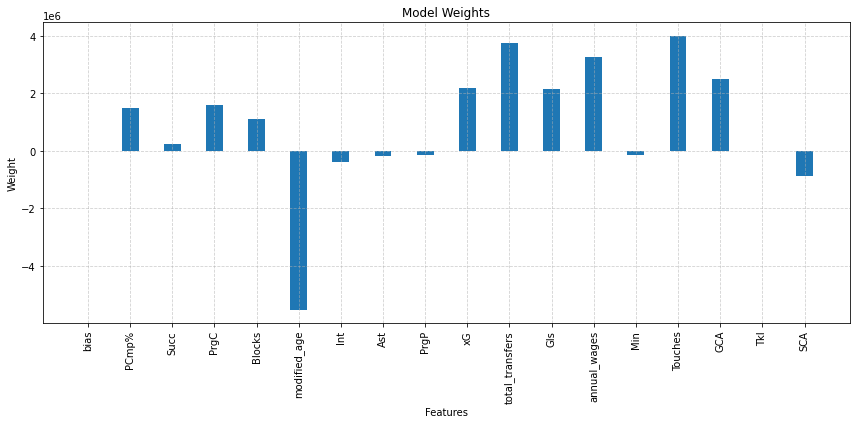

In [96]:
optimized_ridge_weights = optimized_ridge.coef_
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.4
bar_positions = range(len(optimized_ridge_weights))
ax.bar(bar_positions, optimized_ridge_weights, bar_width)
ax.set_xticks(bar_positions)
ax.set_xticklabels(['bias'] + features_to_use, rotation=90)
ax.set_xlabel('Features')
ax.set_ylabel('Weight')
ax.set_title('Model Weights')

ax.grid(linestyle='--', alpha=0.6)

plt.tight_layout()

Top features by importance:

In [97]:
print( "print top k features by importance to show in demo")

print top k features by importance to show in demo


**XGBoost** 

In [112]:
#split data 
X_train, X_test, y_train, y_test = train_test_split(player_data_x, player_data_y, test_size=0.2, random_state=42)

In [113]:
#scale
scaler = StandardScaler()
scaler.fit(X_train)

X_train= scaler.transform(X_train)
X_test = scaler.transform(X_test)

Non-optimized hyperparameters model

In [114]:
# Initialize and fit model
xgb_model = XGBRegressor(objective ='reg:squarederror', n_estimators = 200, learning_rate = 0.1, colsample_bytree=0.8, max_depth=3)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)
y_pred_train = xgb_model.predict(X_train)
# Evaluate model
mse = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error in Testing: {mse}")

mse = mean_absolute_error(y_train, y_pred_train)
print(f"Mean Absolute Error on Training: {mse}")

r2_test = r2_score(y_test, y_pred)
r2_training = r2_score(y_train, y_pred_train)

print(f"R^2: {r2_training}")
print(f"R^2: {r2_test}")

Mean Absolute Error in Testing: 4721293.666043977
Mean Absolute Error on Training: 2538605.8712359676
R^2: 0.9507725117536823
R^2: 0.7597667715180363


Optimizing hyperparameters using grid search

In [115]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [60, 100, 200, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize XGBoost Regressor
xgb_regressor = XGBRegressor()

# Initialize K-Fold cross-validation
kf = KFold(n_splits=10)

# Perform GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(estimator=xgb_regressor, param_grid=param_grid, scoring='r2', cv=kf, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and estimator
best_params = grid_search.best_params_
best_xgb_estimator = grid_search.best_estimator_

# Fit the best estimator on the training data
best_xgb_estimator.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_estimator.predict(X_test)

# Calculate R-squared (R^2) score
r2 = r2_score(y_test, y_pred)

# Print results
print("Optimal Hyperparameters for XGBoost:", best_params)
print("XGBoost R-squared (R^2) on the test set:", r2)

Optimal Hyperparameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200}
XGBoost R-squared (R^2) on the test set: 0.7802889989121715


Feature Importance

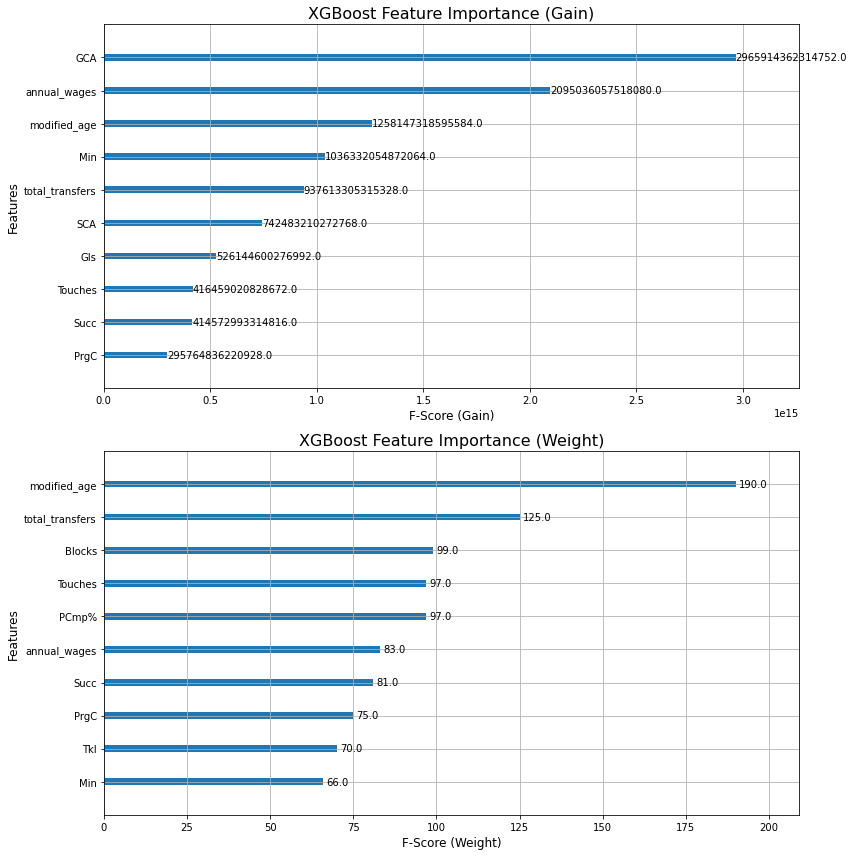

In [172]:
# Set feature names for the model
best_xgb_estimator.feature_names = player_data_x.columns.to_list()

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

best_xgb_estimator.get_booster().feature_names = best_xgb_estimator.feature_names

importance_metrics = ['gain', 'weight']

for i, metric in enumerate(importance_metrics):
    ax = axes[i]
    
    # Plot feature importance for the specified metric
    xgb.plot_importance(best_xgb_estimator, importance_type=metric, max_num_features=10, ax=ax)
    
    # Set titles and labels
    ax.set_title(f'XGBoost Feature Importance ({metric.capitalize()})', fontsize=16)
    ax.set_xlabel(f'F-Score ({metric.capitalize()})', fontsize=12)
    ax.set_ylabel('Features', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [150]:
feature_importances = best_xgb_estimator.feature_importances_
#feature_importances = best_xgb_estimator.get_booster().get_score(importance_type='gain')
feature_names = player_data_x.columns.to_list()
feature_importances = dict(zip(feature_names, feature_importances))
top_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
top_3_features = top_features[:10]

print("Top 10 Most Important Features by 'Gain':")
for i, (feature, importance) in enumerate(top_3_features):
    print(f"{i+1}. Feature: {feature}, Importance: {importance:.4f}")

Top 10 Most Important Features by 'Gain':
1. Feature: GCA, Importance: 0.2534
2. Feature: annual_wages, Importance: 0.1790
3. Feature: modified_age, Importance: 0.1075
4. Feature: Min, Importance: 0.0886
5. Feature: total_transfers, Importance: 0.0801
6. Feature: SCA, Importance: 0.0634
7. Feature: Gls, Importance: 0.0450
8. Feature: Touches, Importance: 0.0356
9. Feature: Succ, Importance: 0.0354
10. Feature: PrgC, Importance: 0.0253


In [154]:
feature_importances = best_xgb_estimator.get_booster().get_score(importance_type='weight')
top_features = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
top_3_features = top_features[:10]

print("Top 10 Most Important Features by 'Weight':")
for i, (feature, importance) in enumerate(top_3_features):
    print(f"{i+1}. Feature: {feature}, Importance: {importance:.4f}")

Top 10 Most Important Features by 'Weight':
1. Feature: modified_age, Importance: 190.0000
2. Feature: total_transfers, Importance: 125.0000
3. Feature: Blocks, Importance: 99.0000
4. Feature: PCmp%, Importance: 97.0000
5. Feature: Touches, Importance: 97.0000
6. Feature: annual_wages, Importance: 83.0000
7. Feature: Succ, Importance: 81.0000
8. Feature: PrgC, Importance: 75.0000
9. Feature: Tkl, Importance: 70.0000
10. Feature: Min, Importance: 66.0000


https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7

**Sickit Learn GradientBoosting** 

Tuning Hyperparameters right away

Yet to do 
- premier league flag
- Random Forrest
- sickit learn representation of boosted trees